In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Data Exploration
- Original Data Source: <a>https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#</a>
- Pandas Ready (not cleaned but ready as you can see in step 1) <a>https://github.com/TrainingByPackt/Data-Science-Projects-with-Python/tree/master/Data</a>
Set info: 

This research aimed at the case of customers default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods. From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients. Because the real probability of default is unknown, this study presented the novel a Sorting Smoothing Method to estimate the real probability of default. 

With the real probability of default as the response variable (Y), and the predictive probability of default as the independent variable (X), the simple linear regression result (Y = A + BX) shows that the forecasting model produced by artificial neural network has the highest coefficient of determination; its regression intercept (A) is close to zero, and regression coefficient (B) to one. Therefore, among the six data mining techniques, artificial neural network is the only one that can accurately estimate the real probability of default.

#### Set Attribute Information:
This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. 

This study reviewed the literature and used the following 23 variables as explanatory variables:

- Limit_Bal: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.

- Sex: Gender (1 = male; 2 = female)

- Education: (1 = graduate school; 2 = university; 3 = high school; 4 = others)

- Marriage: (1 = married; 2 = single; 3 = others)

- Age: (year)


**Note: X6-11 on orginal data set are labeled PAY_1 - PAY_6 here.**

- PAY_1 - PAY_6: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 

- PAY_1 = the repayment status in September, 2005; 

- PAY_2 = the repayment status in August, 2005; . . .;

- PAY_6 = the repayment status in April, 2005. 


**The measurement scale for the repayment status is:**

-   0 = at least a minimum payment was made but the entore balance was not, positive carry over inot next month.

- -1 = pay duly (account had a balance that was paid in full); 

-   1 = payment delay for one month; 

- -2 = account started the month with  0 balance and never used any credit.

-   2 = payment delay for two months; . . .;

-   8 = payment delay for eight months; 

-   9 = payment delay for nine months and above.



**Note: X12-17 on original data set are labeled BILL_AMT1-BILL_AMT6 here.**

- BILL_AMT1-BILL_AMT6: Amount of bill statement (NT dollar). 


**Note: X18-23 om original data set are labeled PAY_AMT1-PAY_AMT6 here.**

**PAY1-6 are a record of past payments. Past monthly payments recorded from April to September.**

- PAY_AMT1-PAY_AMT6: Amount of previous payment (NT dollar). 

- PAY_AMT1 = amount paid in September, 2005; 

- PAY_AMT2 = amount paid in August, 2005; . . .;

- PAY_AMT3 = amount paid in April, 2005.

### The Business Problem:

The client is a credit card company that has brought forth some data for demographics and financials over the past 6 months for a sample of 30k account holders. The data is at the credit account level; in other words, there is one row for each account. Rows are defined whether in the next month after the six month historical data period, the account owner has defaulted or in other words, failed to make the minimum payment. 

#### Objective:
- Develop a predicitve model for whether an account will default next month given given the demographics and historical data. 

In [3]:
# Step 1 - Read in the data set
df = pd.read_excel('../data/default_of_credit_card_clients__courseware_version_1_21_19.xlsx', engine='openpyxl')

In [4]:
# view the data
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,798fc410-45c1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,85698822-43f5,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,0737c11b-be42,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,3b7f77cc-dbc0,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Exploration and Cleaning
- There is quite a bit of cleaning to do!

In [5]:
# get a unique count of ID's
df['ID'].nunique()

29687

In [6]:
# get an overall row count and shape
df.shape

(30000, 25)

In [7]:
# Obviously, there are some dups that need to be explored when there are 30k rows and 29687 unique ID'S. 
# Use value_counts to explore.
id_counts = df['ID'].value_counts()
id_counts.head()

bbffebbc-e3c4    2
e07a0034-42af    2
c5a658d0-92da    2
db91a87c-3cbe    2
9c53fb07-9b73    2
Name: ID, dtype: int64

In [8]:
# split it up to see how many rows have more than one count, simlar to a group by in SQL, group those > 1. We see 313 of them!
id_counts.value_counts()

1    29374
2      313
Name: ID, dtype: int64

#### Create a boolean mask to help clean the dups.

In [9]:
dupe_mask = id_counts == 2

dupe_mask[0:5]

bbffebbc-e3c4    True
e07a0034-42af    True
c5a658d0-92da    True
db91a87c-3cbe    True
9c53fb07-9b73    True
Name: ID, dtype: bool

#### Select and store duplicated ID's in a new varibale called dupe_ids

In [10]:
dupe_ids = id_counts.index[dupe_mask]

# the set was 30k and we had 29687 unique values with the difference being 313.
len(dupe_ids)

313

In [11]:
# lets view the dups in our data frame by using our new varibales to locate them (slicing only 3 for now to view)
df.loc[df['ID'].isin(dupe_ids[0:3]), :]

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
4304,c5a658d0-92da,40000,2,2,1,44,-1,-1,-1,-1,...,4665,4059,5588,4740,922,4665,4059,5588,7000,0
4404,c5a658d0-92da,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7383,bbffebbc-e3c4,60000,1,2,1,54,2,2,0,0,...,37613,39038,37814,55,2400,1316,2000,1531,1477,0
7483,bbffebbc-e3c4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21119,e07a0034-42af,160000,1,1,1,40,0,0,2,2,...,-473,3757,3286,3000,0,0,4700,0,3000,1
21219,e07a0034-42af,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# the above data frame prodcues one row with valid data and one with all 0's but the same account number.
# Create a boolean mask for 0's and get rid of those rows.
df_zero_mask = df == 0

In [13]:
# create a feature zero mask to use the above var to find all cols with 0's 
feature_zero_mask = df_zero_mask.iloc[:,1:].all(axis=1)

In [14]:
# 315 row have zeros for every column but the first one. This is greater than the 313 so if we delete all zero rows,
# we may get rid of the dup id problem.
sum(feature_zero_mask)

315

In [15]:
# clean the data frame by eliminating the rows with all zeros excpet for ID
# note the use of the ~ as a logical NOT operator to select rows with no zeros and : to select all cols.
# the goal is to see if the remaining rows are equal to the unique id's
df_clean1 = df.loc[~feature_zero_mask, :].copy()

In [16]:
# test the total of unique id's
df_clean1.shape

(29685, 25)

In [17]:
# it is a match
df_clean1['ID'].nunique()

29685

In [18]:
# verify each row is not null
df_clean1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29685 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          29685 non-null  object
 1   LIMIT_BAL                   29685 non-null  int64 
 2   SEX                         29685 non-null  int64 
 3   EDUCATION                   29685 non-null  int64 
 4   MARRIAGE                    29685 non-null  int64 
 5   AGE                         29685 non-null  int64 
 6   PAY_1                       29685 non-null  object
 7   PAY_2                       29685 non-null  int64 
 8   PAY_3                       29685 non-null  int64 
 9   PAY_4                       29685 non-null  int64 
 10  PAY_5                       29685 non-null  int64 
 11  PAY_6                       29685 non-null  int64 
 12  BILL_AMT1                   29685 non-null  int64 
 13  BILL_AMT2                   29685 non-null  in

## Examine the features and response variables 
- These may also need to be cleaned after some exploration.
- Start with PAY_1 given we can see in the output above that it is an object but why? All others are int64.

In [20]:
# Quick view of PAY_1
df_clean1['PAY_1'].head()

0     2
1    -1
2     0
3     0
4    -1
Name: PAY_1, dtype: object

**Run a value_counts on the column**

In [21]:
# this gives inisght - "Not available" is a string and pandas defaults the col to a string becasue of this.
df_clean1['PAY_1'].value_counts()

0                13087
-1                5047
1                 3261
Not available     3021
-2                2476
2                 2378
3                  292
4                   63
5                   23
8                   17
6                   11
7                    9
Name: PAY_1, dtype: int64

**For now, remove the "Not available" rows.**

In [22]:
valid_pay_1_mask = df_clean1['PAY_1'] != "Not available"

In [23]:
valid_pay_1_mask[0:5]

0    True
1    True
2    True
3    True
4    True
Name: PAY_1, dtype: bool

In [24]:
# see how many rows we have now, we had 29685 and removed 3021 which = 26664.
sum(valid_pay_1_mask)

26664

**Clean the data by removing with missing values of PAY_1**

In [25]:
df_clean2 = df_clean1.loc[valid_pay_1_mask,:].copy()

In [26]:
# check the shape of the df - its good.
df_clean2.shape

(26664, 25)

**Now the column needs to be converted to an int64**

In [27]:
df_clean2['PAY_1'] = df_clean2['PAY_1'].astype('int64')

In [28]:
# check pay and 2
df_clean2[['PAY_1', 'PAY_2']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26664 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   PAY_1   26664 non-null  int64
 1   PAY_2   26664 non-null  int64
dtypes: int64(2)
memory usage: 624.9 KB


## Explore the demographic features
- Note: we will be dropping Gender as it would be considered unethical to use for prediction.

array([[<AxesSubplot:title={'center':'LIMIT_BAL'}>,
        <AxesSubplot:title={'center':'AGE'}>]], dtype=object)

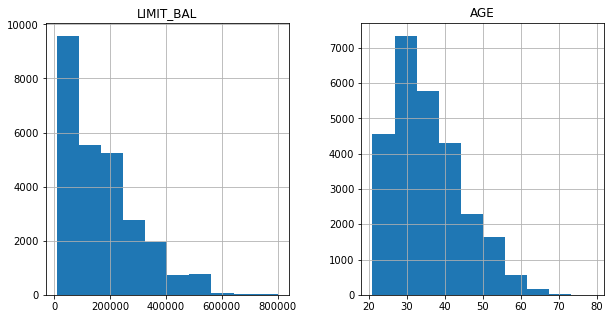

In [32]:
df_clean2[['LIMIT_BAL', 'AGE']].hist(figsize=(10,5))

In [33]:
# get sumary stats
df_clean2[['LIMIT_BAL', 'AGE']].describe()

,LIMIT_BAL,AGE
count,26664.000000,26664.000000
mean,167919.054905,35.505213
std,129839.453081,9.227442
min,10000.000000,21.000000
25%,50000.000000,28.000000
50%,140000.000000,34.000000
75%,240000.000000,41.000000
max,800000.000000,79.000000


**Explore some features**
- LIMIT_BAL and AGE seem to be good and reasonably distributed given the plot and summary.

In [34]:
# explore education - Education: (1 = graduate school; 2 = university; 3 = high school; 4 = others)
df_clean2['EDUCATION'].value_counts()

2    12458
1     9412
3     4380
5      245
4      115
6       43
0       11
Name: EDUCATION, dtype: int64

**There are a few catagories that dont seem to exist - 0, 5, 6**
- We can group these into "other" aka 4.

In [35]:
# group 0,5,6 inpt other
df_clean2['EDUCATION'].replace(to_replace=[0,5,6], value=4, inplace=True)

In [36]:
# all fixed
df_clean2['EDUCATION'].value_counts()

2    12458
1     9412
3     4380
4      414
Name: EDUCATION, dtype: int64

**Get a count for Marriage.**

In [37]:
# Marriage: (1 = married; 2 = single; 3 = others), we have 0 again....
df_clean2['MARRIAGE'].value_counts()

2    14158
1    12172
3      286
0       48
Name: MARRIAGE, dtype: int64

**Group the 0 into "others" = 3**

In [38]:
df_clean2['MARRIAGE'].replace(to_replace=[0], value=3, inplace=True)

In [39]:
# fixed
df_clean2['MARRIAGE'].value_counts()

2    14158
1    12172
3      334
Name: MARRIAGE, dtype: int64

## Implement one hot encoding(OHE) for catagorical features.
- Why are we doing this? More to come... for now, I'm just going to do it.

# ADD INFO ON CAT OHE HERE!!!!!!

**Start with the edcuation catagory whihc has already been "ordered" for us but still needs OHE**

In [40]:
# Creat a dictionary first. We will map to it shortly.
cat_map = {
    1: "graduate school",
    2: "university",
    3: "high school",
    4: "others"
}

**Apply the mapping to a new EDUCATION_CAT column.**

In [41]:
df_clean2['EDUCATION_CAT'] = df_clean2['EDUCATION'].map(cat_map)

In [44]:
# view results
df_clean2[['EDUCATION', 'EDUCATION_CAT']].head(10)

,EDUCATION,EDUCATION_CAT
0,2,university
1,2,university
2,2,university
3,2,university
4,2,university
5,1,graduate school
6,1,graduate school
7,2,university
8,3,high school
9,3,high school


**Now things are ready to OHE.**
- Pass a series of the DF to the pandas get_dummies() function.

In [45]:
# the ordinal values of 1-4 are now gone and a binary classification is used to detect the edcuation!
edu_ohe = pd.get_dummies(df_clean2['EDUCATION_CAT'])

edu_ohe.head()

,graduate school,high school,others,university
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


**Now we concatenate the OHE with the original data frame df_clean2.**

In [54]:
df_with_ohe = pd.concat([df_clean2, edu_ohe], axis=1)

df_with_ohe[['EDUCATION_CAT','graduate school', 'high school', 'others', 'university']].head()

,EDUCATION_CAT,graduate school,high school,others,university
0,university,0,0,0,1
1,university,0,0,0,1
2,university,0,0,0,1
3,university,0,0,0,1
4,university,0,0,0,1


## Save this as a new data file

In [55]:
df_with_ohe.to_csv('../data/ohe_cleaned_data.csv', index=False)

## Explore the financial history features in the dataset

In [ ]:
# import the cleaned data set from above
df= pd.read_csv('../data/ohe_cleaned_data.csv')